In [1]:
!pip install transformers -q
!pip install sentencepiece -q

In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [5]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [6]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [7]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [8]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [9]:
def get_metrics(actual, predicted, average='micro'):
  return f1_score(actual, predicted, average=average), precision_score(actual, predicted, average=average), recall_score(actual, predicted, average=average)

In [10]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    f1, p, r = get_metrics(train_labels, train_predictions, average=average)
    results['train_precision'].append(p)
    results['train_recall'].append(r)
    results['train_f1'].append(f1)
    f1, p, r = get_metrics(validation_labels, validation_predictions, average=average)
    results['validation_precision'].append(p)
    results['validation_recall'].append(r)
    results['validation_f1'].append(f1)
    f1, p, r = get_metrics(test_lbls, test_preds, average=average)
    results['test_precision'].append(p)
    results['test_recall'].append(r)
    results['test_f1'].append(f1)
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [11]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [12]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [14]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [15]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [16]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    cv_score = {'train_predictions': [],
                'validation_predictions': [],
                'train_labels': [],
                'validation_labels': [],
                'test_predictions' : [],
                'test_labels' : []
                }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
        cv_score['train_labels'] = cv_score['train_labels'] + best_scores['train_labels'].tolist()
        cv_score['train_predictions'] = cv_score['train_predictions'] + best_scores['train_predictions'].tolist()
        cv_score['validation_labels'] = cv_score['validation_labels'] + best_scores['validation_labels'].tolist()
        cv_score['validation_predictions'] = cv_score['validation_predictions'] + best_scores['validation_predictions'].tolist()
        cv_score['test_labels'] = cv_score['test_labels'] + best_scores['test_labels'].tolist()
        cv_score['test_predictions'] = cv_score['test_predictions'] + best_scores['test_predictions'].tolist()
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    cv_result = {}
    cv_result['validation_f1'], cv_result['validation_precision'], cv_result['validation_recall'] = get_metrics(cv_score['validation_labels'],cv_score['validation_predictions'])
    cv_result['test_f1'], cv_result['test_precision'], cv_result['test_recall'] = get_metrics(cv_score['test_labels'],cv_score['test_predictions'])
    cv_result['train_f1'], cv_result['train_precision'], cv_result['train_recall'] = get_metrics(cv_score['train_labels'],cv_score['train_predictions'])
    print('*** Cross Validation Score ***')
    cv_result = pd.DataFrame(cv_result, index=[0]) # Scalar values
    display(HTML(cv_result.to_html().replace("\\n", "<br>")))
    return results

In [17]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [18]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=100)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [19]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/10 : Training Loss: 3.418 / Validation Loss : 3.397 [Time : 17.986192 seconds]
Epoch 2/10 : Training Loss: 3.398 / Validation Loss : 3.393 [Time : 17.354163 seconds]
Epoch 3/10 : Training Loss: 3.394 / Validation Loss : 3.389 [Time : 17.399266 seconds]
Epoch 4/10 : Training Loss: 3.393 / Validation Loss : 3.396 [Time : 16.57391 seconds]
Epoch 5/10 : Training Loss: 3.401 / Validation Loss : 3.396 [Time : 16.577605 seconds]
Epoch 6/10 : Training Loss: 3.398 / Validation Loss : 3.388 [Time : 17.383636 seconds]
Epoch 7/10 : Training Loss: 3.388 / Validation Loss : 3.380 [Time : 17.382458 seconds]
Epoch 8/10 : Training Loss: 3.381 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 13.043 / Validation Loss : 4.114 [Time : 16.60226 seconds]
Epoch 2/10 : Training Loss: 3.571 / Validation Loss : 1.776 [Time : 17.316697 seconds]
Epoch 3/10 : Training Loss: 1.842 / Validation Loss : 0.875 [Time : 17.324006 seconds]
Epoch 4/10 : Training Loss: 0.966 / Validation Loss : 0.479 [Time : 17.385757 seconds]
Epoch 5/10 : Training Loss: 0.600 / Validation Loss : 0.298 [Time : 17.413538 seconds]
Epoch 6/10 : Training Loss: 0.378 / Validation Loss : 0.221 [Time : 17.36871 seconds]
Epoch 7/10 : Training Loss: 0.298 / Validation Loss : 0.170 [Time : 17.381271 seconds]
Epoch 8/10 : Training Loss: 0.230 / Validation Loss : 0.127 [Time : 17.372247 seconds]
Epoch 9/10 : Training Loss: 0.194 / Validation Loss : 0.111 [Time : 17.350404 seconds]
Epoch 10/10 : Training Loss: 0.146 / Validation Loss : 0.078 [Time : 17.388096 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.482 / Validation Loss : 3.402 [Time : 16.557155 seconds]
Epoch 2/10 : Training Loss: 3.416 / Validation Loss : 3.397 [Time : 16.484416 seconds]
Epoch 3/10 : Training Loss: 3.422 / Validation Loss : 3.395 [Time : 16.498735 seconds]
Epoch 4/10 : Training Loss: 3.408 / Validation Loss : 3.392 [Time : 16.494711 seconds]
Epoch 5/10 : Training Loss: 3.408 / Validation Loss : 3.390 [Time : 16.483916 seconds]
Epoch 6/10 : Training Loss: 3.403 / Validation Loss : 3.386 [Time : 16.542444 seconds]
Epoch 7/10 : Training Loss: 3.396 / Validation Loss : 3.384 [Time : 16.505981 seconds]
Epoch 8/10 : Training Loss: 3.401 / Validation Loss : 3.387 [Time : 16.483834 seconds]
Epoch 9/10 : Training Loss: 3.398 / Validation Loss : 3.377 [Time : 16.508762 seconds]
Epoch 10/10 : Training Loss: 3.389 / Validation Loss : 3.370 [Time : 16.59465 seconds]
*** Confusion Matrix - Training ***
[[ 8  1  0  0  0  1  1  0  5  3  1  0  2  0  0  0  6  0  1  0  0  0  1  1
   0  0  1  0  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.434 / Validation Loss : 3.209 [Time : 16.745935 seconds]
Epoch 2/10 : Training Loss: 3.163 / Validation Loss : 3.048 [Time : 16.891629 seconds]
Epoch 3/10 : Training Loss: 3.005 / Validation Loss : 2.879 [Time : 16.556225 seconds]
Epoch 4/10 : Training Loss: 2.842 / Validation Loss : 2.711 [Time : 16.534307 seconds]
Epoch 5/10 : Training Loss: 2.672 / Validation Loss : 2.547 [Time : 16.548468 seconds]
Epoch 6/10 : Training Loss: 2.510 / Validation Loss : 2.389 [Time : 16.524691 seconds]
Epoch 7/10 : Training Loss: 2.347 / Validation Loss : 2.235 [Time : 16.543481 seconds]
Epoch 8/10 : Training Loss: 2.199 / Validation Loss : 2.092 [Time : 16.569789 seconds]
Epoch 9/10 : Training Loss: 2.053 / Validation Loss : 1.961 [Time : 16.578194 seconds]
Epoch 10/10 : Training Loss: 1.918 / Validation Loss : 1.829 [Time : 16.501725 seconds]
*** Confusion Matrix - Training ***
[[25  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  2
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 26.480 / Validation Loss : 8.056 [Time : 16.612735 seconds]
Epoch 2/10 : Training Loss: 7.109 / Validation Loss : 3.431 [Time : 16.526408 seconds]
Epoch 3/10 : Training Loss: 3.597 / Validation Loss : 1.580 [Time : 16.544294 seconds]
Epoch 4/10 : Training Loss: 1.975 / Validation Loss : 0.704 [Time : 16.591785 seconds]
Epoch 5/10 : Training Loss: 0.968 / Validation Loss : 0.392 [Time : 16.572897 seconds]
Epoch 6/10 : Training Loss: 0.621 / Validation Loss : 0.225 [Time : 16.558669 seconds]
Epoch 7/10 : Training Loss: 0.424 / Validation Loss : 0.140 [Time : 16.585832 seconds]
Epoch 8/10 : Training Loss: 0.321 / Validation Loss : 0.102 [Time : 16.618482 seconds]
Epoch 9/10 : Training Loss: 0.181 / Validation Loss : 0.073 [Time : 17.385882 seconds]
Epoch 10/10 : Training Loss: 0.175 / Validation Loss : 0.072 [Time : 17.380196 seconds]
*** Confusion Matrix - Training ***
[[31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  

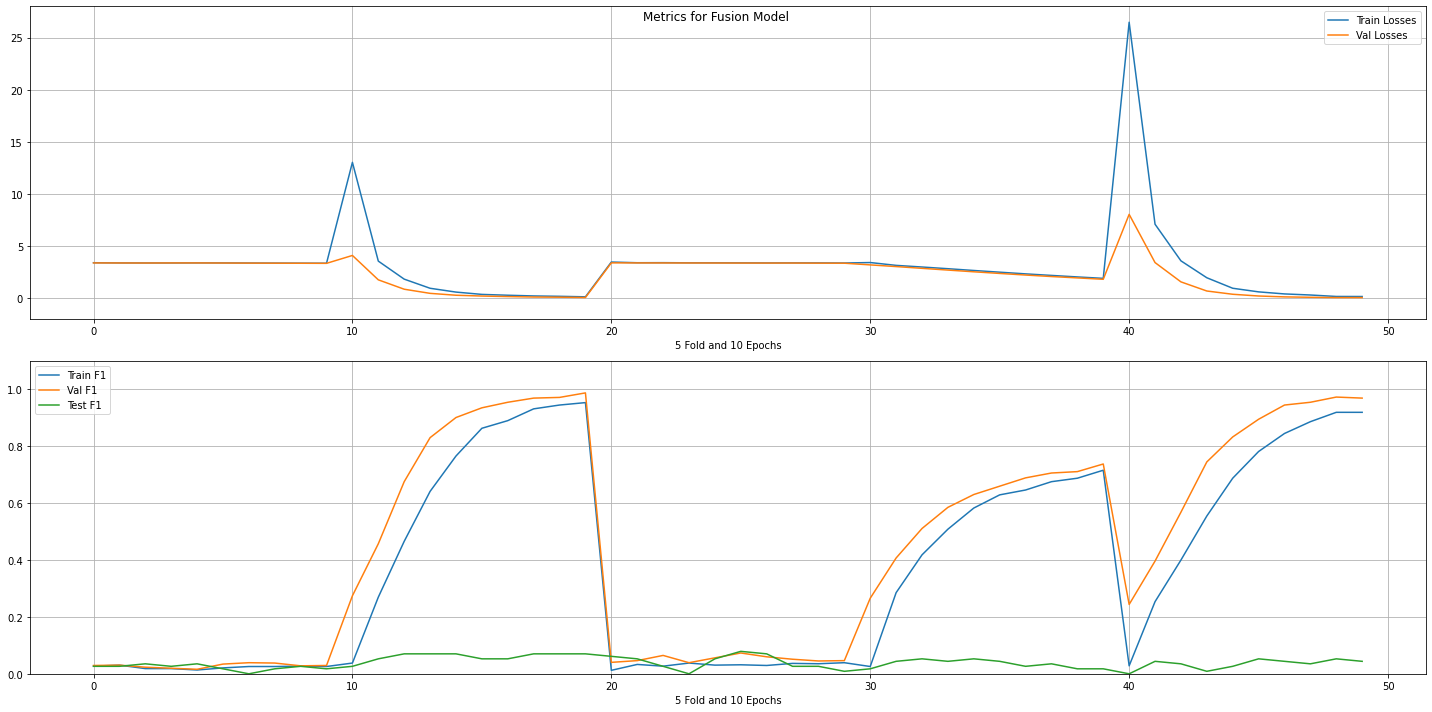

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.554146,0.554146,0.554146,0.031579,0.031579,0.031579,0.530732,0.530732,0.530732


In [20]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [21]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.953659,0.987805,0.070175,0.953659,0.987805,0.070175,0.953659,0.987805,0.070175
8,0.919512,0.973171,0.052632,0.919512,0.973171,0.052632,0.919512,0.973171,0.052632
8,0.945122,0.971951,0.070175,0.945122,0.971951,0.070175,0.945122,0.971951,0.070175
7,0.931707,0.969512,0.070175,0.931707,0.969512,0.070175,0.931707,0.969512,0.070175
9,0.919512,0.969512,0.043860,0.919512,0.969512,0.043860,0.919512,0.969512,0.043860
6,0.890244,0.954878,0.052632,0.890244,0.954878,0.052632,0.890244,0.954878,0.052632
7,0.886585,0.954878,0.035088,0.886585,0.954878,0.035088,0.886585,0.954878,0.035088
6,0.845122,0.945122,0.043860,0.845122,0.945122,0.043860,0.845122,0.945122,0.043860
5,0.863415,0.935366,0.052632,0.863415,0.935366,0.052632,0.863415,0.935366,0.052632
4,0.765854,0.901220,0.070175,0.765854,0.901220,0.070175,0.765854,0.901220,0.070175


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/10 : Training Loss: 3.416 / Validation Loss : 3.395 [Time : 21.173931 seconds]
Epoch 2/10 : Training Loss: 3.397 / Validation Loss : 3.389 [Time : 20.059744 seconds]
Epoch 3/10 : Training Loss: 3.391 / Validation Loss : 3.384 [Time : 20.038866 seconds]
Epoch 4/10 : Training Loss: 3.385 / Validation Loss : 3.377 [Time : 20.209122 seconds]
Epoch 5/10 : Training Loss: 3.380 / Validation Loss : 3.371 [Time : 20.199387 seconds]
Epoch 6/10 : Training Loss: 3.372 / Validation Loss : 3.363 [Time : 20.114714 seconds]
Epoch 7/10 : Training Loss: 3.365 / Validation Loss : 3.356 [Time : 19.998749 seconds]
Epoch 8/10 : Training Loss: 3.359 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.427 / Validation Loss : 3.401 [Time : 16.688802 seconds]
Epoch 2/10 : Training Loss: 3.402 / Validation Loss : 3.397 [Time : 16.245192 seconds]
Epoch 3/10 : Training Loss: 3.402 / Validation Loss : 3.395 [Time : 16.293774 seconds]
Epoch 4/10 : Training Loss: 3.399 / Validation Loss : 3.394 [Time : 16.28263 seconds]
Epoch 5/10 : Training Loss: 3.397 / Validation Loss : 3.392 [Time : 16.21544 seconds]
Epoch 6/10 : Training Loss: 3.395 / Validation Loss : 3.389 [Time : 16.197128 seconds]
Epoch 7/10 : Training Loss: 3.393 / Validation Loss : 3.387 [Time : 16.163841 seconds]
Epoch 8/10 : Training Loss: 3.390 / Validation Loss : 3.385 [Time : 16.190153 seconds]
Epoch 9/10 : Training Loss: 3.387 / Validation Loss : 3.381 [Time : 16.232275 seconds]
Epoch 10/10 : Training Loss: 3.385 / Validation Loss : 3.377 [Time : 16.182364 seconds]
*** Confusion Matrix - Training ***
[[11  0  0  1  0  0  0  0 11  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  5]


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.085 / Validation Loss : 2.599 [Time : 20.382666 seconds]
Epoch 2/10 : Training Loss: 2.383 / Validation Loss : 1.907 [Time : 20.475513 seconds]
Epoch 3/10 : Training Loss: 1.818 / Validation Loss : 1.463 [Time : 20.110784 seconds]
Epoch 4/10 : Training Loss: 1.440 / Validation Loss : 1.140 [Time : 20.243358 seconds]
Epoch 5/10 : Training Loss: 1.123 / Validation Loss : 0.900 [Time : 20.038672 seconds]
Epoch 6/10 : Training Loss: 0.900 / Validation Loss : 0.717 [Time : 20.049618 seconds]
Epoch 7/10 : Training Loss: 0.725 / Validation Loss : 0.579 [Time : 20.124199 seconds]
Epoch 8/10 : Training Loss: 0.577 / Validation Loss : 0.469 [Time : 20.037347 seconds]
Epoch 9/10 : Training Loss: 0.478 / Validation Loss : 0.386 [Time : 20.100743 seconds]
Epoch 10/10 : Training Loss: 0.400 / Validation Loss : 0.325 [Time : 20.233215 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.444 / Validation Loss : 3.401 [Time : 17.03132 seconds]
Epoch 2/10 : Training Loss: 3.405 / Validation Loss : 3.399 [Time : 16.22356 seconds]
Epoch 3/10 : Training Loss: 3.409 / Validation Loss : 3.398 [Time : 16.259229 seconds]
Epoch 4/10 : Training Loss: 3.405 / Validation Loss : 3.396 [Time : 16.20344 seconds]
Epoch 5/10 : Training Loss: 3.404 / Validation Loss : 3.395 [Time : 16.184776 seconds]
Epoch 6/10 : Training Loss: 3.401 / Validation Loss : 3.393 [Time : 16.199539 seconds]
Epoch 7/10 : Training Loss: 3.401 / Validation Loss : 3.393 [Time : 16.189003 seconds]
Epoch 8/10 : Training Loss: 3.399 / Validation Loss : 3.391 [Time : 16.345697 seconds]
Epoch 9/10 : Training Loss: 3.396 / Validation Loss : 3.387 [Time : 16.175564 seconds]
Epoch 10/10 : Training Loss: 3.395 / Validation Loss : 3.387 [Time : 16.180117 seconds]
*** Confusion Matrix - Training ***
[[ 1  0  0  0  0  0  2  0  1  2  0  0  3  0  0  0  0  1  0  0  1  3  0  3
   7  0  0  0  2  6]
 

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.432 / Validation Loss : 3.392 [Time : 16.628754 seconds]
Epoch 2/10 : Training Loss: 3.393 / Validation Loss : 3.382 [Time : 16.18431 seconds]
Epoch 3/10 : Training Loss: 3.387 / Validation Loss : 3.374 [Time : 16.206301 seconds]
Epoch 4/10 : Training Loss: 3.377 / Validation Loss : 3.363 [Time : 16.217034 seconds]
Epoch 5/10 : Training Loss: 3.367 / Validation Loss : 3.353 [Time : 16.201376 seconds]
Epoch 6/10 : Training Loss: 3.359 / Validation Loss : 3.342 [Time : 16.206745 seconds]
Epoch 7/10 : Training Loss: 3.347 / Validation Loss : 3.333 [Time : 16.247751 seconds]
Epoch 8/10 : Training Loss: 3.339 / Validation Loss : 3.320 [Time : 16.588433 seconds]
Epoch 9/10 : Training Loss: 3.325 / Validation Loss : 3.307 [Time : 16.223305 seconds]
Epoch 10/10 : Training Loss: 3.314 / Validation Loss : 3.295 [Time : 16.186655 seconds]
*** Confusion Matrix - Training ***
[[14  0  4  0  2  0  2  0  3  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  2  0  0  4  0]

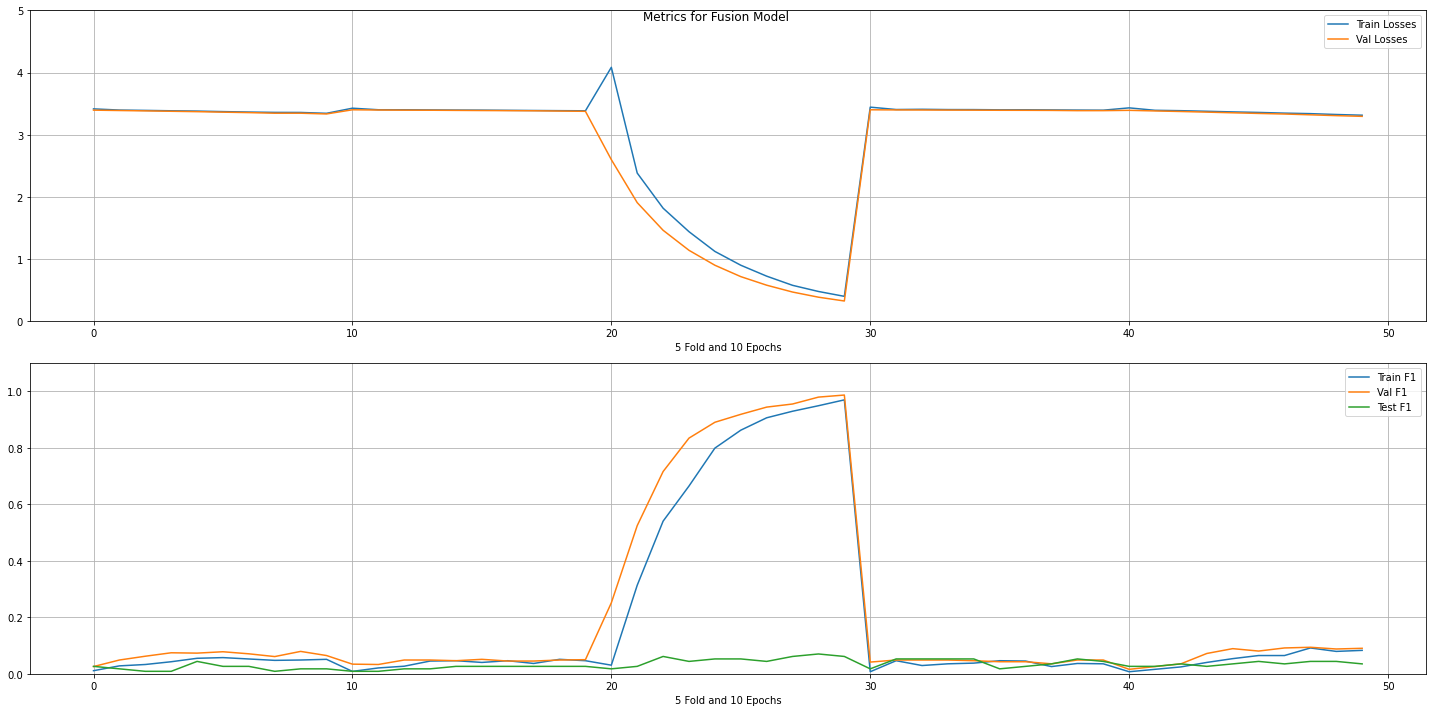

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.248049,0.248049,0.248049,0.038596,0.038596,0.038596,0.237317,0.237317,0.237317


In [22]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [23]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.969512,0.986585,0.061404,0.969512,0.986585,0.061404,0.969512,0.986585,0.061404
8,0.948780,0.979268,0.070175,0.948780,0.979268,0.070175,0.948780,0.979268,0.070175
7,0.929268,0.954878,0.061404,0.929268,0.954878,0.061404,0.929268,0.954878,0.061404
6,0.906098,0.943902,0.043860,0.906098,0.943902,0.043860,0.906098,0.943902,0.043860
5,0.862195,0.918293,0.052632,0.862195,0.918293,0.052632,0.862195,0.918293,0.052632
4,0.798780,0.890244,0.052632,0.798780,0.890244,0.052632,0.798780,0.890244,0.052632
3,0.664634,0.834146,0.043860,0.664634,0.834146,0.043860,0.664634,0.834146,0.043860
2,0.540244,0.715854,0.061404,0.540244,0.715854,0.061404,0.540244,0.715854,0.061404
1,0.313415,0.524390,0.026316,0.313415,0.524390,0.026316,0.313415,0.524390,0.026316
0,0.030488,0.251220,0.017544,0.030488,0.251220,0.017544,0.030488,0.251220,0.017544


# XLM-R Fusion

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/10 : Training Loss: 3.677 / Validation Loss : 2.579 [Time : 21.52488 seconds]
Epoch 2/10 : Training Loss: 2.429 / Validation Loss : 1.991 [Time : 21.538729 seconds]
Epoch 3/10 : Training Loss: 1.888 / Validation Loss : 1.542 [Time : 21.410127 seconds]
Epoch 4/10 : Training Loss: 1.489 / Validation Loss : 1.210 [Time : 21.45945 seconds]
Epoch 5/10 : Training Loss: 1.180 / Validation Loss : 0.961 [Time : 21.468204 seconds]
Epoch 6/10 : Training Loss: 0.938 / Validation Loss : 0.768 [Time : 21.330249 seconds]
Epoch 7/10 : Training Loss: 0.761 / Validation Loss : 0.622 [Time : 22.299278 seconds]
Epoch 8/10 : Training Loss: 0.626 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.643 / Validation Loss : 2.866 [Time : 17.21516 seconds]
Epoch 2/10 : Training Loss: 2.766 / Validation Loss : 2.361 [Time : 17.074112 seconds]
Epoch 3/10 : Training Loss: 2.273 / Validation Loss : 1.958 [Time : 17.135411 seconds]
Epoch 4/10 : Training Loss: 1.918 / Validation Loss : 1.626 [Time : 16.849355 seconds]
Epoch 5/10 : Training Loss: 1.600 / Validation Loss : 1.358 [Time : 16.73656 seconds]
Epoch 6/10 : Training Loss: 1.351 / Validation Loss : 1.138 [Time : 16.725062 seconds]
Epoch 7/10 : Training Loss: 1.137 / Validation Loss : 0.958 [Time : 16.718786 seconds]
Epoch 8/10 : Training Loss: 0.951 / Validation Loss : 0.807 [Time : 16.855117 seconds]
Epoch 9/10 : Training Loss: 0.820 / Validation Loss : 0.683 [Time : 16.895028 seconds]
Epoch 10/10 : Training Loss: 0.696 / Validation Loss : 0.581 [Time : 16.786581 seconds]
*** Confusion Matrix - Training ***
[[31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.437 / Validation Loss : 3.401 [Time : 17.214995 seconds]
Epoch 2/10 : Training Loss: 3.404 / Validation Loss : 3.398 [Time : 17.100456 seconds]
Epoch 3/10 : Training Loss: 3.404 / Validation Loss : 3.396 [Time : 17.148961 seconds]
Epoch 4/10 : Training Loss: 3.402 / Validation Loss : 3.393 [Time : 16.866656 seconds]
Epoch 5/10 : Training Loss: 3.399 / Validation Loss : 3.390 [Time : 16.726164 seconds]
Epoch 6/10 : Training Loss: 3.394 / Validation Loss : 3.387 [Time : 16.758011 seconds]
Epoch 7/10 : Training Loss: 3.394 / Validation Loss : 3.383 [Time : 16.714289 seconds]
Epoch 8/10 : Training Loss: 3.390 / Validation Loss : 3.378 [Time : 16.805067 seconds]
Epoch 9/10 : Training Loss: 3.388 / Validation Loss : 3.375 [Time : 16.739103 seconds]
Epoch 10/10 : Training Loss: 3.383 / Validation Loss : 3.373 [Time : 16.729846 seconds]
*** Confusion Matrix - Training ***
[[ 0  4  0  0  1  0  0  0  0  3  0  0  0  0  1  1 18  1  0  0  0  0  0  0
   0  3  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.457 / Validation Loss : 3.389 [Time : 17.224011 seconds]
Epoch 2/10 : Training Loss: 3.394 / Validation Loss : 3.374 [Time : 17.09168 seconds]
Epoch 3/10 : Training Loss: 3.388 / Validation Loss : 3.361 [Time : 17.077875 seconds]
Epoch 4/10 : Training Loss: 3.376 / Validation Loss : 3.348 [Time : 16.850242 seconds]
Epoch 5/10 : Training Loss: 3.359 / Validation Loss : 3.333 [Time : 16.742362 seconds]
Epoch 6/10 : Training Loss: 3.347 / Validation Loss : 3.319 [Time : 16.674585 seconds]
Epoch 7/10 : Training Loss: 3.333 / Validation Loss : 3.304 [Time : 16.755864 seconds]
Epoch 8/10 : Training Loss: 3.316 / Validation Loss : 3.284 [Time : 16.705141 seconds]
Epoch 9/10 : Training Loss: 3.295 / Validation Loss : 3.267 [Time : 16.697357 seconds]
Epoch 10/10 : Training Loss: 3.294 / Validation Loss : 3.264 [Time : 16.694257 seconds]
*** Confusion Matrix - Training ***
[[11  1  4  2  1  0  0  1  1  0  0  3  0  1  0  0  0  2  0  0  0  0  0  2
   0  0  0  3  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.929 / Validation Loss : 2.566 [Time : 17.147489 seconds]
Epoch 2/10 : Training Loss: 2.410 / Validation Loss : 1.929 [Time : 17.071785 seconds]
Epoch 3/10 : Training Loss: 1.848 / Validation Loss : 1.489 [Time : 17.07534 seconds]
Epoch 4/10 : Training Loss: 1.440 / Validation Loss : 1.169 [Time : 16.926447 seconds]
Epoch 5/10 : Training Loss: 1.149 / Validation Loss : 0.924 [Time : 16.751119 seconds]
Epoch 6/10 : Training Loss: 0.908 / Validation Loss : 0.737 [Time : 16.72918 seconds]
Epoch 7/10 : Training Loss: 0.733 / Validation Loss : 0.593 [Time : 16.725692 seconds]
Epoch 8/10 : Training Loss: 0.596 / Validation Loss : 0.478 [Time : 16.759986 seconds]
Epoch 9/10 : Training Loss: 0.484 / Validation Loss : 0.393 [Time : 16.712036 seconds]
Epoch 10/10 : Training Loss: 0.395 / Validation Loss : 0.324 [Time : 21.42961 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 

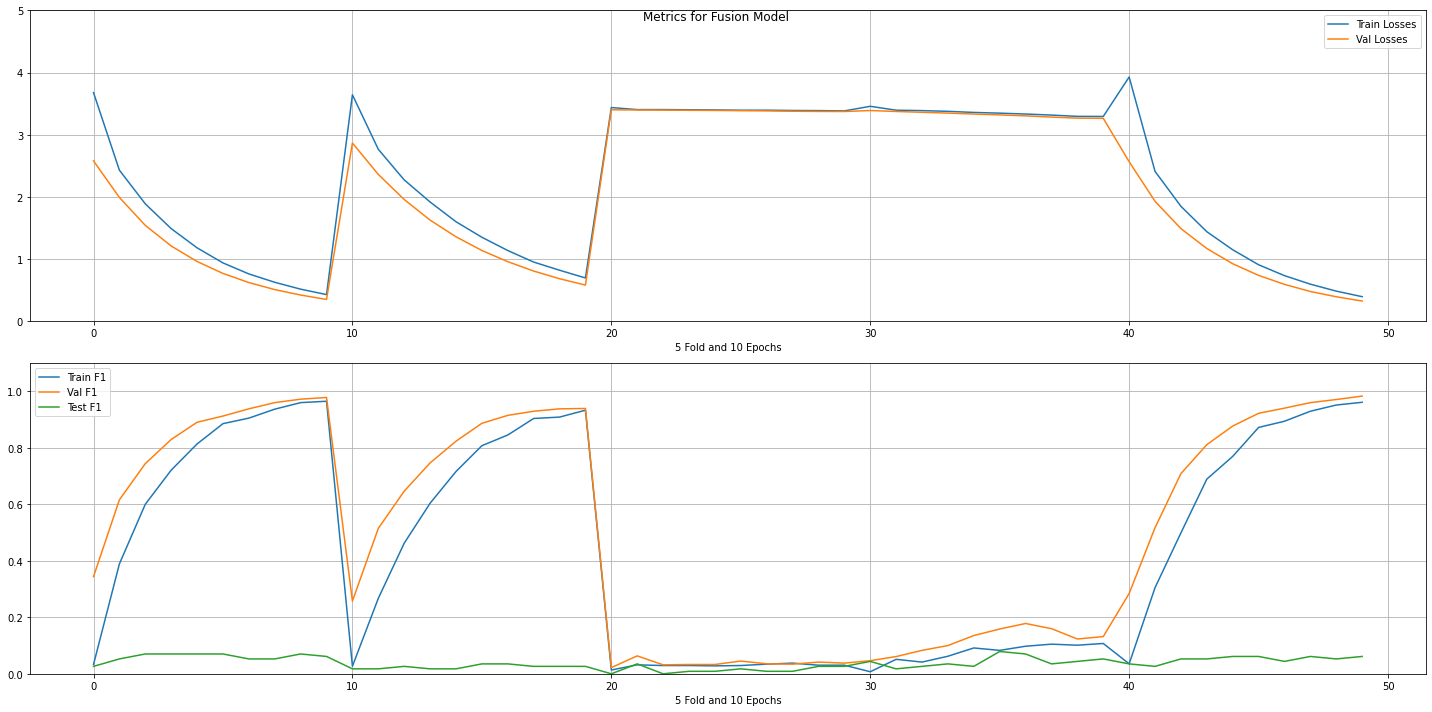

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.613902,0.613902,0.613902,0.045614,0.045614,0.045614,0.599268,0.599268,0.599268


In [24]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [25]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.960976,0.982927,0.061404,0.960976,0.982927,0.061404,0.960976,0.982927,0.061404
9,0.964634,0.978049,0.061404,0.964634,0.978049,0.061404,0.964634,0.978049,0.061404
8,0.959756,0.971951,0.070175,0.959756,0.971951,0.070175,0.959756,0.971951,0.070175
8,0.951220,0.970732,0.052632,0.951220,0.970732,0.052632,0.951220,0.970732,0.052632
7,0.936585,0.959756,0.052632,0.936585,0.959756,0.052632,0.936585,0.959756,0.052632
7,0.929268,0.959756,0.061404,0.929268,0.959756,0.061404,0.929268,0.959756,0.061404
6,0.893902,0.940244,0.043860,0.893902,0.940244,0.043860,0.893902,0.940244,0.043860
9,0.932927,0.939024,0.026316,0.932927,0.939024,0.026316,0.932927,0.939024,0.026316
8,0.908537,0.937805,0.026316,0.908537,0.937805,0.026316,0.908537,0.937805,0.026316
6,0.904878,0.937805,0.052632,0.904878,0.937805,0.052632,0.904878,0.937805,0.052632


# MBERT Fusion

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/10 : Training Loss: 3.408 / Validation Loss : 3.385 [Time : 19.793637 seconds]
Epoch 2/10 : Training Loss: 3.384 / Validation Loss : 3.372 [Time : 18.78194 seconds]
Epoch 3/10 : Training Loss: 3.372 / Validation Loss : 3.361 [Time : 19.686153 seconds]
Epoch 4/10 : Training Loss: 3.359 / Validation Loss : 3.351 [Time : 18.117986 seconds]
Epoch 5/10 : Training Loss: 3.353 / Validation Loss : 3.340 [Time : 18.214169 seconds]
Epoch 6/10 : Training Loss: 3.338 / Validation Loss : 3.325 [Time : 19.34989 seconds]
Epoch 7/10 : Training Loss: 3.326 / Validation Loss : 3.312 [Time : 18.213895 seconds]
Epoch 8/10 : Training Loss: 3.323 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.479 / Validation Loss : 3.000 [Time : 19.163931 seconds]
Epoch 2/10 : Training Loss: 2.911 / Validation Loss : 2.644 [Time : 19.306419 seconds]
Epoch 3/10 : Training Loss: 2.560 / Validation Loss : 2.306 [Time : 19.160041 seconds]
Epoch 4/10 : Training Loss: 2.234 / Validation Loss : 2.002 [Time : 19.290576 seconds]
Epoch 5/10 : Training Loss: 1.949 / Validation Loss : 1.742 [Time : 19.141482 seconds]
Epoch 6/10 : Training Loss: 1.699 / Validation Loss : 1.533 [Time : 19.314125 seconds]
Epoch 7/10 : Training Loss: 1.500 / Validation Loss : 1.338 [Time : 18.965798 seconds]
Epoch 8/10 : Training Loss: 1.312 / Validation Loss : 1.178 [Time : 19.256432 seconds]
Epoch 9/10 : Training Loss: 1.159 / Validation Loss : 1.041 [Time : 18.776162 seconds]
Epoch 10/10 : Training Loss: 1.027 / Validation Loss : 0.926 [Time : 19.137831 seconds]
*** Confusion Matrix - Training ***
[[26  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 8.470 / Validation Loss : 3.354 [Time : 16.311396 seconds]
Epoch 2/10 : Training Loss: 2.959 / Validation Loss : 1.718 [Time : 16.133261 seconds]
Epoch 3/10 : Training Loss: 1.704 / Validation Loss : 1.050 [Time : 16.192904 seconds]
Epoch 4/10 : Training Loss: 1.110 / Validation Loss : 0.706 [Time : 20.726562 seconds]
Epoch 5/10 : Training Loss: 0.742 / Validation Loss : 0.491 [Time : 19.922504 seconds]
Epoch 6/10 : Training Loss: 0.561 / Validation Loss : 0.372 [Time : 20.421562 seconds]
Epoch 7/10 : Training Loss: 0.428 / Validation Loss : 0.291 [Time : 19.929793 seconds]
Epoch 8/10 : Training Loss: 0.324 / Validation Loss : 0.226 [Time : 20.530105 seconds]
Epoch 9/10 : Training Loss: 0.249 / Validation Loss : 0.177 [Time : 20.286189 seconds]
Epoch 10/10 : Training Loss: 0.197 / Validation Loss : 0.144 [Time : 20.592506 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.002 / Validation Loss : 2.751 [Time : 15.903854 seconds]
Epoch 2/10 : Training Loss: 2.409 / Validation Loss : 1.605 [Time : 16.099879 seconds]
Epoch 3/10 : Training Loss: 1.521 / Validation Loss : 1.061 [Time : 16.161794 seconds]
Epoch 4/10 : Training Loss: 1.069 / Validation Loss : 0.754 [Time : 16.167522 seconds]
Epoch 5/10 : Training Loss: 0.770 / Validation Loss : 0.557 [Time : 16.193827 seconds]
Epoch 6/10 : Training Loss: 0.581 / Validation Loss : 0.432 [Time : 16.171063 seconds]
Epoch 7/10 : Training Loss: 0.470 / Validation Loss : 0.353 [Time : 16.15312 seconds]
Epoch 8/10 : Training Loss: 0.373 / Validation Loss : 0.285 [Time : 16.170913 seconds]
Epoch 9/10 : Training Loss: 0.302 / Validation Loss : 0.230 [Time : 16.15691 seconds]
Epoch 10/10 : Training Loss: 0.247 / Validation Loss : 0.188 [Time : 16.168012 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 9.106 / Validation Loss : 3.054 [Time : 15.879781 seconds]
Epoch 2/10 : Training Loss: 2.643 / Validation Loss : 1.336 [Time : 16.092102 seconds]
Epoch 3/10 : Training Loss: 1.433 / Validation Loss : 0.791 [Time : 16.161443 seconds]
Epoch 4/10 : Training Loss: 0.819 / Validation Loss : 0.491 [Time : 16.180641 seconds]
Epoch 5/10 : Training Loss: 0.585 / Validation Loss : 0.396 [Time : 16.171963 seconds]
Epoch 6/10 : Training Loss: 0.416 / Validation Loss : 0.255 [Time : 16.19207 seconds]
Epoch 7/10 : Training Loss: 0.280 / Validation Loss : 0.181 [Time : 16.154807 seconds]
Epoch 8/10 : Training Loss: 0.203 / Validation Loss : 0.136 [Time : 21.015559 seconds]
Epoch 9/10 : Training Loss: 0.166 / Validation Loss : 0.112 [Time : 19.825639 seconds]
Epoch 10/10 : Training Loss: 0.130 / Validation Loss : 0.088 [Time : 20.324396 seconds]
*** Confusion Matrix - Training ***
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]

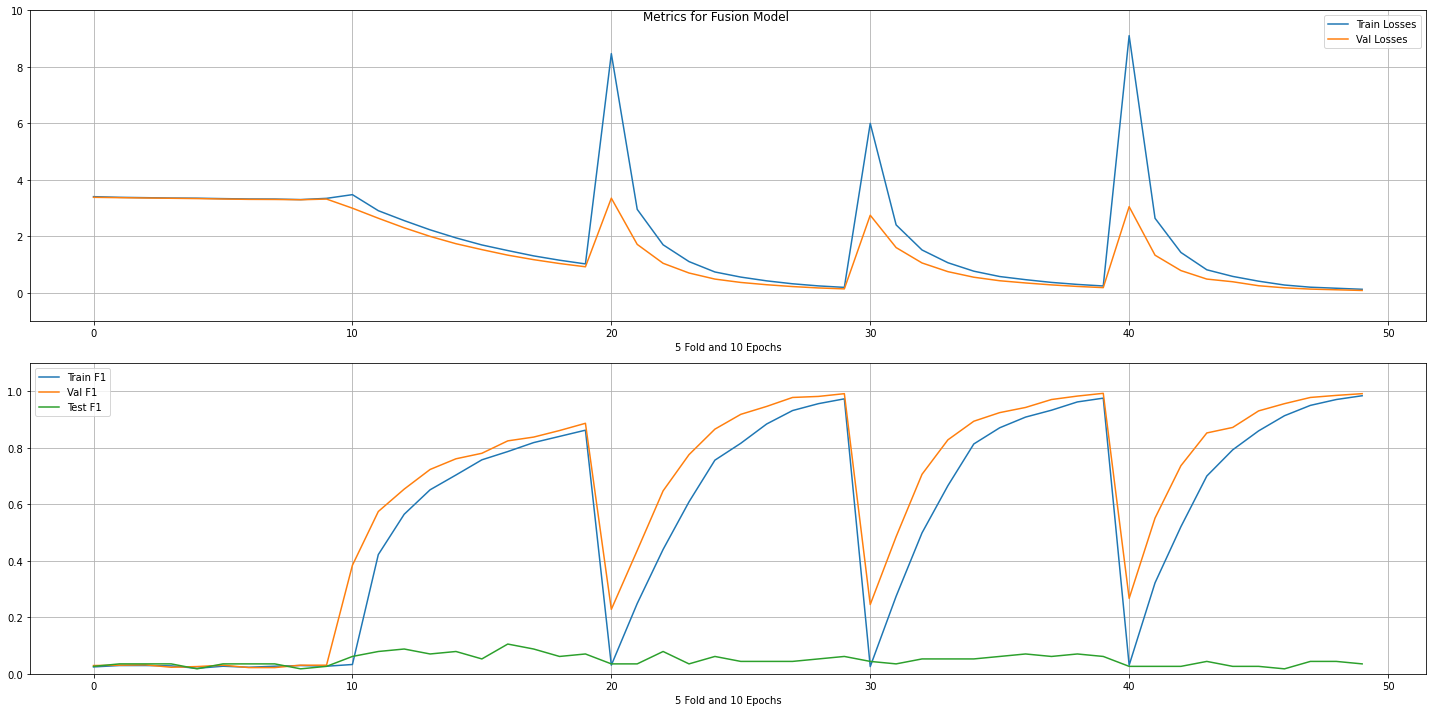

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.778537,0.778537,0.778537,0.049123,0.049123,0.049123,0.764878,0.764878,0.764878


In [26]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [28]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.975610,0.992683,0.061404,0.975610,0.992683,0.061404,0.975610,0.992683,0.061404
9,0.984146,0.991463,0.035088,0.984146,0.991463,0.035088,0.984146,0.991463,0.035088
9,0.973171,0.991463,0.061404,0.973171,0.991463,0.061404,0.973171,0.991463,0.061404
8,0.970732,0.985366,0.043860,0.970732,0.985366,0.043860,0.970732,0.985366,0.043860
8,0.962195,0.982927,0.070175,0.962195,0.982927,0.070175,0.962195,0.982927,0.070175
8,0.956098,0.981707,0.052632,0.956098,0.981707,0.052632,0.956098,0.981707,0.052632
7,0.950000,0.978049,0.043860,0.950000,0.978049,0.043860,0.950000,0.978049,0.043860
7,0.931707,0.978049,0.043860,0.931707,0.978049,0.043860,0.931707,0.978049,0.043860
7,0.932927,0.970732,0.061404,0.932927,0.970732,0.061404,0.932927,0.970732,0.061404
6,0.913415,0.956098,0.017544,0.913415,0.956098,0.017544,0.913415,0.956098,0.017544
